# TERM PROJECT 보고서
## 2022110206 조현

## (1) 주제 선정이유

선정 주제: 대중들이 많이 듣는 노래는 어떤 특징을 갖고있는가

"snack culture" 는 문화의 흐름에서 주요 키워드가 되어가고있다. 음악산업계에도 이전과 다르게 3분이 넘지 않는 곡들이 많아지며 시대의 흐름에 민감하게 반응하는 듯하다. 그렇다면 전세계에서 가장 대중 적인 곡들또한 "snack culture"의 흐름을 주도하는 곡들일까?
대중들이 많이들은 2023년의 노래들과 코로나 이전 2019년도의 노래들을 분석하고, 어떤 종류의 노래들을 대중들이 선호했는지 알아보자.

## (2) 가설

시간이 지날수록 짧은 노래를 사람들이 많이 듣고, 음원 차트에 많이 들었던 노래들은 대부분 에너지가 높은 노래들이 많을 것이다.

## (3) 인터넷을 통한 데이터 획득

spotify for developer에 가입을 해서 spotify의 api를 설치한다. 그리고  open api를 통해 2023년과 2018년 가장많이 재생된 노래들에 대한 정보들을 가져온다. 노래의 특징들을 분석할때 장르들을 추출하는 것이 optimal 한 선택이겠지만 spotify open api에선 track의 장르정보는 제공하지 않으므로 track들의 audio features 를 추출하여 노래의 특징을 분석한다.


spotify: https://open.spotify.com  
spotify for developer: https://developer.spotify.com/documentation/web-api

## (4) 분석을 위한 데이터의 가공

1. spotify에 접근하기 위해선 id와 secret코드가 필요하다. 이는 <create app> 으로 들어가 자신의 app을 생성함으로써 발급받을 수 있다.
2. 그렇게 spotify의 open api를 사용할 수 있는 코드는 먼저 입력한 후, 분석하고자 하는 Billboard Hot100 플레이리스트의 playlist id를 추출한다
(playlist id는 url의 마지막 슬래시('/')뒤에 있는 문자열이다)
3. 각 track을 분석하기 위해선 track id를 추출해야하므로 반복문을 통해 track id를 추출하는 함수를 만든다
4. 추출한 track id들을 통해 각 track의 audio feature들을 추출하는 함수도 생성한다.
5. 마지막으로 함수들을 선언하고 data들을 csv 파일로 저장하도록한다.

In [2]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler



client_id = 'c916f07a97f647a38eccf09d4485365a'
client_secret = '0645a0a973224d7ba095266e88d9f6dd'

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [3]:
ids=[]
tracks=[]
df=[]
final_df=[]

# track ID를 구하는 함수
def get_trackID(playlist_id):
    ids=[]
    playlist=sp.playlist(playlist_id)
    for item in playlist['tracks']['items']:
        track=item['track']
        ids.append(track['id'])
    return ids

ids=get_trackID(playlist_id)
    # audio feature을 분석하는 함수
def getTrackFeatures(id):
    meta=sp.track(id)
    features=sp.audio_features(id)

    name=meta['name']
    length=meta['duration_ms']
    popularity=meta['popularity']
    acousticness=features[0]['acousticness']
    danceability=features[0]['danceability']
    energy=features[0]['energy']
    instrumentalness=features[0]['instrumentalness']
    liveness=features[0]['liveness']
    loudness=features[0]['loudness']
    tempo=features[0]['tempo']
    valence=features[0]['valence']

    track=[ name, length, popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, tempo, valence]
    return track

    #audio feature 저장 함수
def make_tracks(ids):
    for i in range(len(ids)):
        track=getTrackFeatures(ids[i])
        tracks.append(track)
    return tracks




In [4]:
#track들의 길이를 나타내는 그래프생성 함수
def show_length(df):
    sns.histplot(data=df, x="length")
# 모든 트랙의 길이의 평균 계산
    average_length_ms = df['length'].mean()
    average_length_sec = average_length_ms / 1000  
    print(f'Average track length: {average_length_sec:.2f} seconds')
#adudio feature간의 상관관계
def corr_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    corr_matrix = df[numeric_cols].corr()
    sns.set(rc={'figure.figsize': (12, 10)})
    sns.heatmap(corr_matrix, annot=True, cmap='Reds')
    plt.show()
    
#audio features 평균 계산후 그래프 출력 함수1
def new_dataframe(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns # 문자열 열을 제외한 숫자 열만 선택
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled, columns=numeric_cols) # 스케일링된 데이터를 데이터프레임으로 변환
    final_df = pd.concat([df[df.columns.difference(numeric_cols)], scaled_df], axis=1) # 스케일링된 데이터와 원래 문자열 데이터를 합침
    final_df=final_df.loc[:, ~final_df.columns.str.contains('^Unnamed: 0')] #unnamed 열 삭제
    return final_df

#audio features 평균 계산후 그래프 출력 함수2
def audio_features_mean(final_df):
    numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
    mean_vals = final_df[numeric_cols].mean() # 각 audio features의 평균
    # 평균 값 그래프 그리기
    fig, ax = plt.subplots(figsize=(10, 7))
    mean_vals.plot(kind='barh', ax=ax, width=0.3)
    plt.xlabel("Mean Value")
    plt.ylabel("Audio Features")
    # 막대 위에 평균 값 표시
    for index, value in enumerate(mean_vals): 
        ax.text(value, index, f'{value:.2f}', va='center')
    plt.show()

## (5) 분석 결과 도출

csv로 정리된 파일을 통해 
1. track의 길이 분포
2. audio feature들의 상관관계
3. 인기에 영향을 많이 미치는 audio feature  
들을 알아보도록 하자

In [5]:
playlist_id1 = '37i9dQZF1DX18jTM2l2fJY' # 2023년 top track
ids1=get_trackID(playlist_id1)
file_name1="spotify top track 2023.csv"
make_tracks(ids1)
df1=pd.DataFrame(tracks, columns=['name', 'length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
df1.to_csv(file_name1,sep=',') #csv 파일 생성


In [6]:
chart1= pd.read_csv(file_name1)
chart1.head(10)

,Unnamed: 0,name,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence
0,0,Flowers,200600,90,0.0584,0.706,0.691,0.000070,0.0232,-4.775,118.048,0.632
1,1,Kill Bill,153946,86,0.0521,0.644,0.735,0.144000,0.1610,-5.747,88.980,0.418
2,2,As It Was,167303,91,0.3420,0.520,0.731,0.001010,0.3110,-5.338,173.930,0.662
3,3,Seven (feat. Latto) (Explicit Ver.),183550,85,0.3120,0.790,0.831,0.000000,0.0797,-4.185,124.987,0.872
4,4,Ella Baila Sola,165671,77,0.4830,0.668,0.758,0.000019,0.0837,-5.176,147.989,0.834
5,5,Cruel Summer,178426,93,0.1170,0.552,0.702,0.000021,0.1050,-5.707,169.994,0.564
6,6,Creepin' (with The Weeknd & 21 Savage),221520,84,0.3910,0.716,0.613,0.000000,0.0813,-6.018,97.914,0.157
7,7,Calm Down (with Selena Gomez),239317,75,0.3820,0.801,0.806,0.000669,0.1140,-5.206,106.999,0.802
8,8,"Shakira: Bzrp Music Sessions, Vol. 53",214945,78,0.2810,0.842,0.745,0.000026,0.1180,-4.231,122.060,0.530
9,9,Anti-Hero,200690,85,0.1210,0.633,0.648,0.000003,0.1610,-6.645,96.888,0.490


Average track length: 200.35 seconds


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



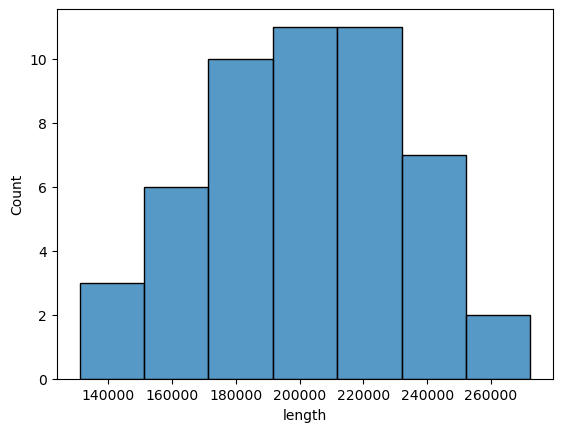

In [7]:
show_length(df1) #track 길이를 나타내는 그래프

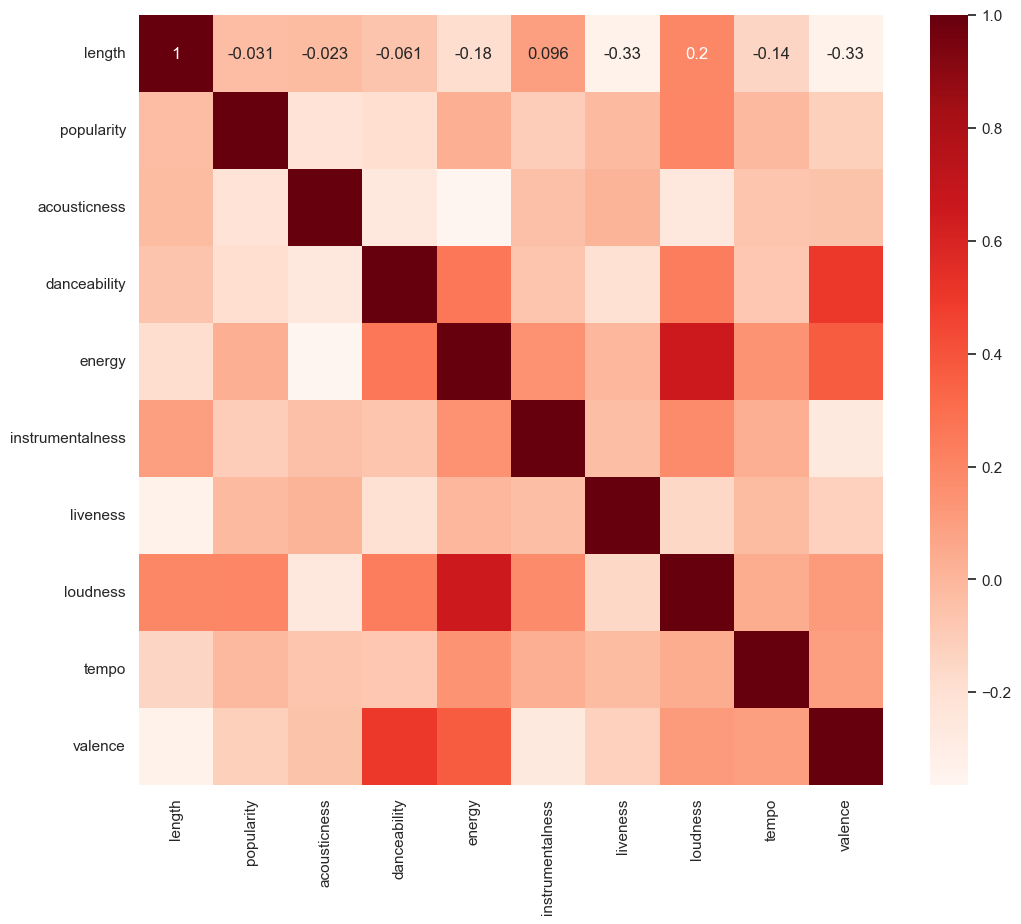

In [8]:
corr_features(df1) #audio feature들의 상관관계를 나나태는 그래프

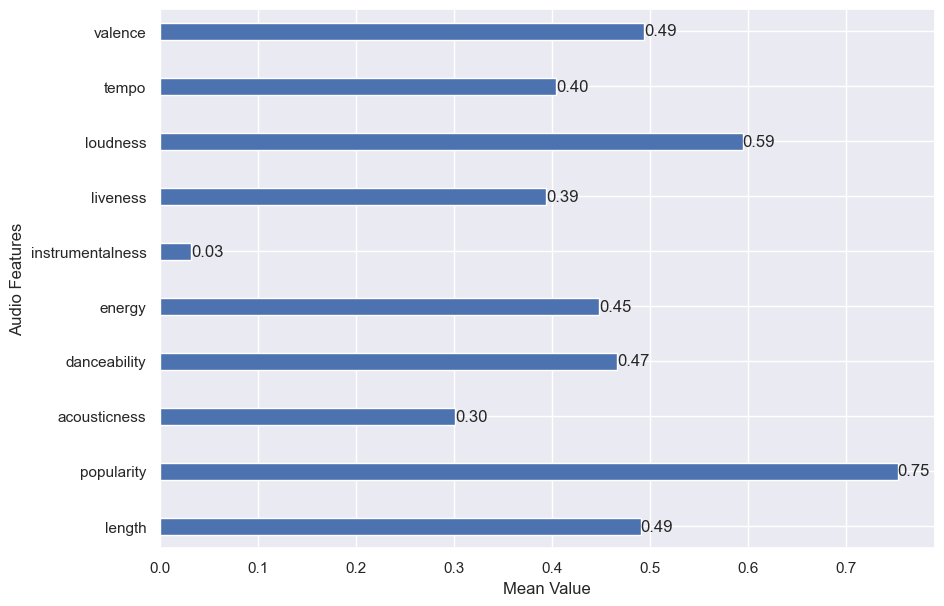

In [9]:
final_df=new_dataframe(df1)
audio_features_mean(final_df) #audio feaure들의 평균값을 나타내는 그래프

In [10]:
playlist_id2 = '37i9dQZF1DXe2bobNYDtW8' #2018년 top track
ids2=get_trackID(playlist_id2)
file_name2="spotify top track 2018.csv"
make_tracks(ids2)
df2=pd.DataFrame(tracks, columns=['name', 'length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
df2.to_csv(file_name2,sep=',') #csv 파일 저장



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Average track length: 208.21 seconds


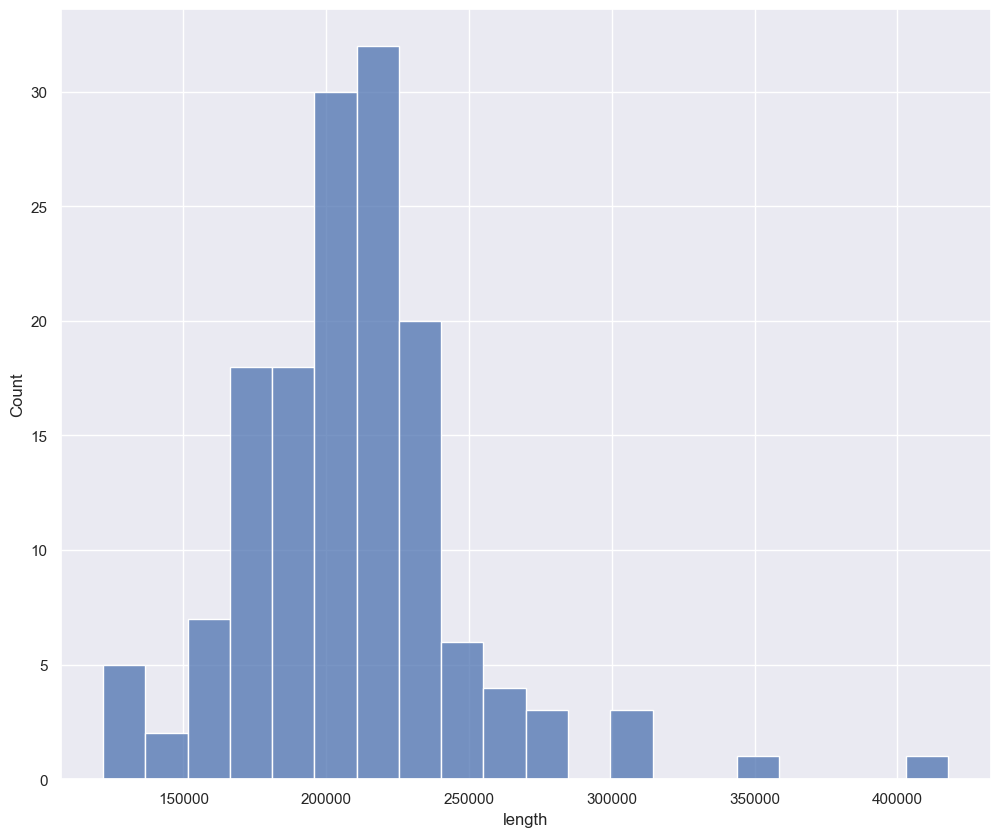

In [14]:
show_length(df2) # track의 길이를 나타내는 그래프

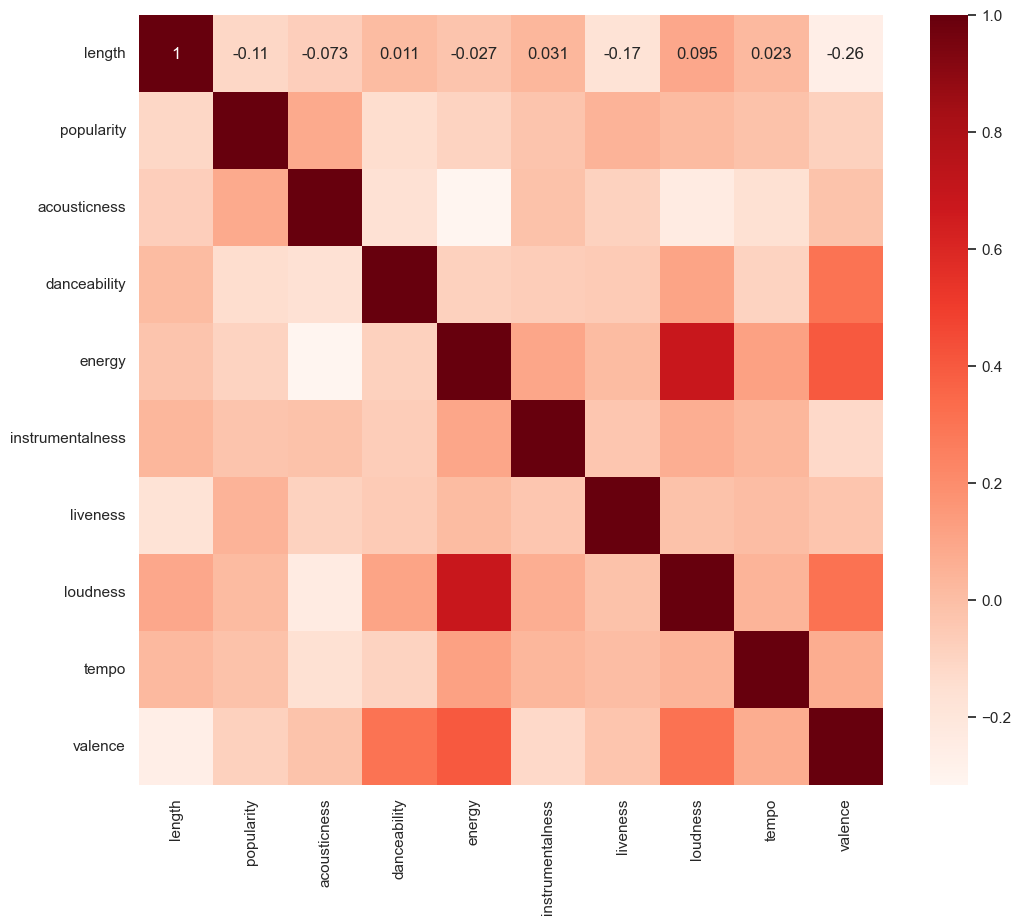

In [12]:
corr_features(df2) # audio feature들의 상관관계를 나타내는 그래프

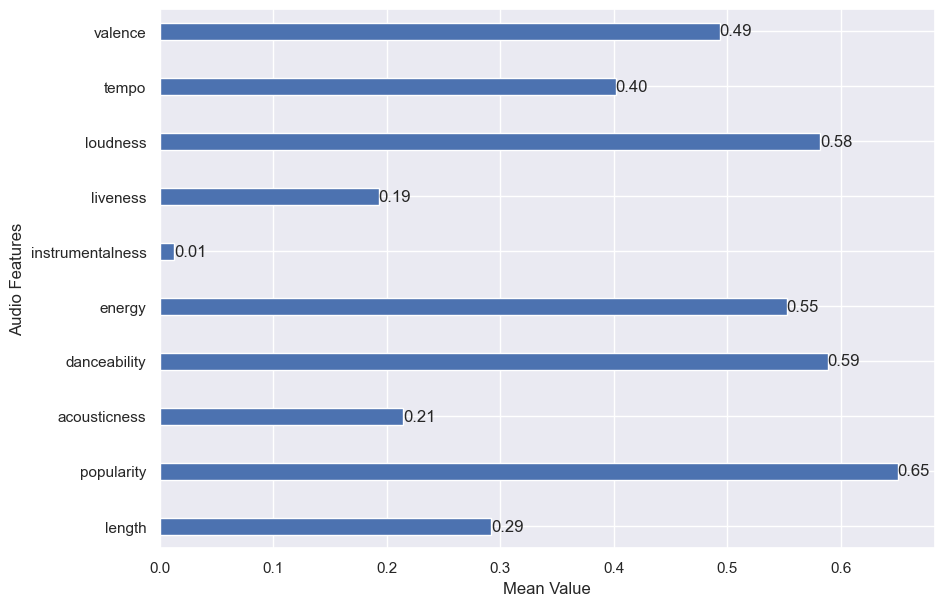

In [13]:
final_df=new_dataframe(df2)
audio_features_mean(final_df) #audio feature들의 평균값을 나타내는 그래프

## (6) 결론

1. 2023년의 곡 길이 평균과 2018년의 곡 길이 평균은 각각 200.35초, 208.21초로 8초정도 줄어들긴 했지만, 유의미한 차이는 보이지 않았다.
2. 각 audio feature들의 상관관계로 미루어 봤을때 2개의 데이터 모두 loudness - energy, valence - dancability가 가장 밀접한 관계를 띄고있음을 드러낸다.
   유의미하게 볼것은 2023년엔 loudness가 popularity와 가장 밀접한 관계를 나타냈지만, 2018년엔 acousticness가 popularity와 가장 밀접한 관계를 나타냈다.
3. 2018년이나 2023년이나 가장 많이 들은 노래들은 공통적으로 loudness, energy, danceability, valence가 높은 특징을 드러낸다

따라서 시간이 지나도 전세계적으로 가장많이 사랑을 받은 노래들은 snack culture 처럼 짧고 자극적인 컨텐츠가 아니라, 곡의 길이의 큰 상관없이 대시벨이 높고, 경쾌하고, 신난다는 특징을 갖고있다. 


## (7) 참고문헌

spotify open api: https://developer.spotify.com  
스포티파이 api로 음악분석: https://velog.io/@mare-solis/스포티파이-API로-음악-분석하기  
analyzing audio features from spotify: https://keviinkibe.medium.com/analyzing-audio-features-from-spotify-api-99dd0b781849  
data analysis with spotify api: https://medium.com/@eelopez088/data-analysis-with-spotify-api-a1507f48e9b0


## (8) 별첨 :(3)의 획득한 데이터 원본

spotify top track 2023.csv  
spotify top track 2018.csv  
(압축파일에 같이 첨부됨)

## (9) 별첨 :(4)의 획득한 데이터 원본

spotify top track 2023.csv  
spotify top track 2018.csv  
(압축파일에 같이 첨부됨)

## (10) 별첨: (3)을 (4)로 변환하는 등의 작업을 위하여 본인이 직접 개발한 Python 소스코드 원본


In [ ]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt

def make_tracks(ids):
    for i in range(len(ids)):
        track=getTrackFeatures(ids[i])
        tracks.append(track)
    return tracks

playlist_id1 = '37i9dQZF1DX18jTM2l2fJY'
ids1=get_trackID(playlist_id1)
file_name1="spotify top track 2023.csv"
make_tracks(ids1)
df1=pd.DataFrame(tracks, columns=['name', 'length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
df1.to_csv(file_name1,sep=',')

playlist_id2 = '37i9dQZF1DXe2bobNYDtW8'
ids2=get_trackID(playlist_id2)
file_name2="spotify top track 2018.csv"
make_tracks(ids2)
df2=pd.DataFrame(tracks, columns=['name', 'length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
df2.to_csv(file_name2,sep=',')